In [3]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.style.use('JFM')

from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = {
# 0.2:[0.320878628692,0.014354985748],
# 0.4:[0.28759238955,0.0173941871764],
# 0.8:[0.179652184681,0.012733736384],
# 1.2:[0.152164204092,0.0106738755021],
# 1.6:[0.144804252876,0.00974592070867],
# 2.0:[0.142805206381,0.0110827643436],
0.2:[0.574137882739,0.117924053771],
0.4:[0.516598893174,0.0517583826384],
0.8:[0.34328828939,0.0357882812154],
1.2:[0.288284913923,0.0232571237128],
1.6:[0.284424366299,0.0325989118031],
2.0:[0.245942817302,0.0164289592739],
}

def get_Rij(fname):
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats])
    d = {}
    d['R11'] = dat[:,0]
    d['R12'] = dat[:,1]
    d['R22'] = dat[:,3]  
    return d#R11,R12,R22


R12= {
0.2: [0.125101149986,0.0172575563936],
0.4: [0.118250103618,0.00134024224413],
0.8: [0.236087782843,0.00628209528105],
1.2: [0.289875680321,0.0235116520145],
1.6: [0.261011171416,0.0113426256528],
2.0: [0.296152055571,0.00463855966876],
}


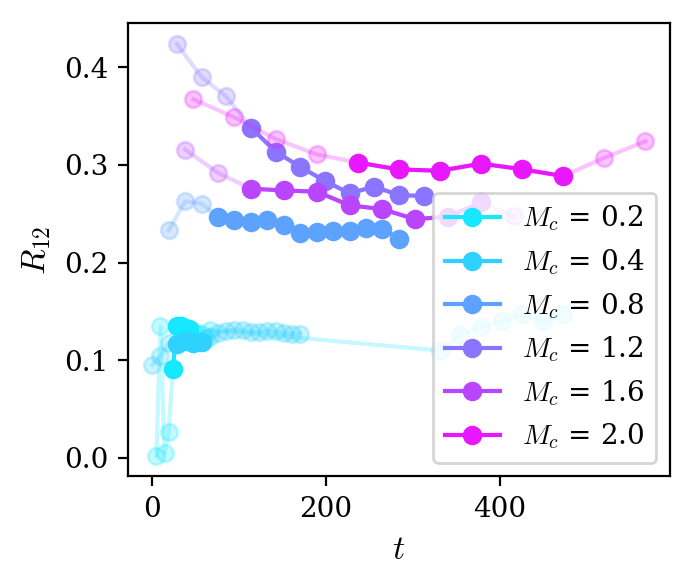

In [91]:
s = '1'
Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)


for Rij_plot in ['R12',]:
    print(Rij_plot + '= {')
    fig = plt.figure(figsize=(3.5,3),dpi=200)
    for i,Mc in enumerate(Mc_list):
        if Mc is '04' or Mc is '02':
            dir_out = '/home/kmatsuno/ShearLayerData/temporal/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        else:
            dir_out = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        directory = dir_out
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        tlist,dlist,rates = growth_rates(directory+'shearlayer_')
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)
        
        flist = glob.glob(directory+"shearlayer_Rij*")
        flist.sort()

#         if Mc=='02': ist=5;ien=-3
#         elif Mc=='04': ist=9;ien=None
#         elif Mc=='08': ist=5;ien=None
#         elif Mc=='12': ist=8;ien=None
#         elif Mc=='16': ist=6;ien=-2
#         elif Mc=='20': ist=4;ien=None
        if Mc=='02': ist=5;ien=10 # mira run
        #if Mc=='02': ist=-8;ien=-4 # theta run
        #elif Mc=='04': ist=8;ien=14 #mira run
        elif Mc=='04': ist=4;ien=8 #theta run
        elif Mc=='08': ist=4;ien=None
        elif Mc=='12': ist=4;ien=None
        elif Mc=='16': ist=3;ien=-1
        elif Mc=='20': ist=5;ien=-2
        else: ist=0; ien=None 
            
        colorVal = scalarMap.to_rgba(inp.Mc)
        mat = np.zeros([2,len(flist)])
        
        for j,fname in enumerate(flist[:]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            idx = np.argmin(abs(tlist-time))
            dtheta = dlist[idx]
            eta = y/dtheta
            
            # Get y lscale
            thresh = 0.1
            autocorr = np.fromfile(directory+'lscale_vv_%04d.dat'%tID,sep=' ')
            autocorr = np.reshape(autocorr,[Ny,3])
            ly,i1,i2 = get_lscale(y,autocorr[:,0],thresh=thresh)
            
            # Get corresponding du
#             utilde = np.fromfile(directory+'/shearlayer_utilde_%04d.dat'%tID,sep=' ')
#             ic = np.argmin(abs(utilde))
#             du = abs(utilde[i2]-utilde[i1])
            
            scale = 1./(du[inp.Mc][0]*inp.du)**2 # (inp.du*ly/dtheta)**2
            d = get_Rij(fname)
            
            mat[0,j] = time*inp.du
            mat[1,j] = abs(1./dtheta * integrate_y(y,d[Rij_plot]*scale))
        
        isort = np.argsort(mat[0,:])
        mat[0,:] = mat[0,isort]
        mat[1,:] = mat[1,isort]
        plt.plot(mat[0,1:]-mat[0,0],mat[1,1:],'-o',alpha=0.25,color=colorVal)
        plt.plot(mat[0,ist:ien]-mat[0,0],mat[1,ist:ien],'-o',color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
        print('{}: [{},{}],'.format(inp.Mc,np.mean(mat[1,ist:ien]),np.std(mat[1,ist:ien])))
        
    if Rij_plot =='R11': Rij_title = r'$R_{11}$'
    if Rij_plot =='R12': Rij_title = r'$R_{12}$'
    if Rij_plot =='R22': Rij_title = r'$R_{22}$'
    #plt.xlim([-12,12])
    plt.xlabel(r'$t$')
    plt.ylabel(Rij_title)
    plt.legend(fontsize=10)
    print('}')


Text(0.55,0.3,'(c)')

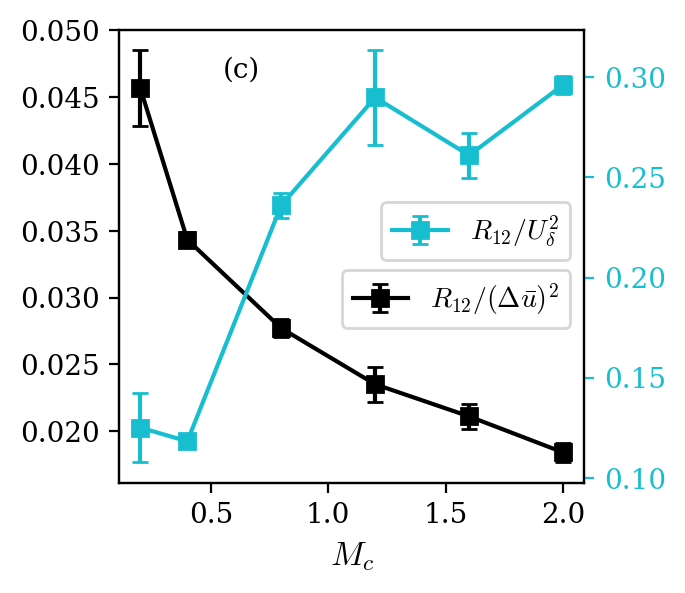

In [7]:
def plotter_v2(ax,dat,fmt,label=None,colorVal='k'):
    Mcs = []
    vals = []
    errs = []
    for Mc in sorted(dat.keys()):
        Mcs.append( Mc )
        vals.append( dat[Mc][0] )
        errs.append( dat[Mc][1] )
    plt.errorbar(Mcs,vals,color=colorVal,yerr=errs,fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=200)
ax = plt.gca()
ax.set_xlabel(r'$M_c$')
plotter_v2(ax,Rij_orig['R12'],'-s',r'$R_{12}/(\Delta\bar{u})^2$')
plt.legend(fontsize=10,bbox_to_anchor=(1,0.50))

ax2 = plt.twinx()
plotter_v2(ax2,Rij_new['R12'],'-s',r'$R_{12}/U_\delta^2$',colorVal='C9')
ax2.tick_params(axis='y', labelcolor='C9',color='C9')

plt.legend(fontsize=10,bbox_to_anchor=(1,0.65))
plt.annotate('(c)',(0.55,0.3),fontsize=10)

In [5]:
# New scaling by U_L^2
Rij_new = {}
Rij_new['R11'] = {}
Rij_new['R12'] = {
0.2: [0.125101149986,0.0172575563936],
0.4: [0.118250103618,0.00134024224413],
0.8: [0.236087782843,0.00628209528105],
1.2: [0.289875680321,0.0235116520145],
1.6: [0.261011171416,0.0113426256528],
2.0: [0.296152055571,0.00463855966876],
}
Rij_new['R22'] = {
}

In [4]:
#Original scaling by dU^2
Rij_orig = {}

Rij_orig['R11'] = {

}
Rij_orig['R12'] = {
0.2: [0.0456629330454,0.00283329740091],
0.4: [0.0343358155018,0.000553860981348],
0.8: [0.0277103853925,0.000669233090265],
1.2: [0.0235177354016,0.00131687190244],
1.6: [0.0211150781942,0.000917586884456],
2.0: [0.0184216813684,0.000731641980017],
# 0.2: [-0.0484441607275,0.00432265242925],
# 0.4: [-0.0373876404285,0.0011257859663],
# 0.8: [-0.0277103853925,0.000669233090265],
# 1.2: [-0.0230926113216,0.000870668416715],
# 1.6: [-0.020911496487,0.000920959361589],
# 2.0: [-0.0180395650086,0.000403323428575],
}
Rij_orig['R22'] = {

}

In [24]:
#Freund scaling (dU*delta_y/delta_theta)^2
Rij_freund = {}

Rij_freund['R11'] = {

}
Rij_freund['R12'] = {

}
Rij_freund['R22'] = {

}